In [ ]:
#| default_exp data.core
#| default_cls_lvl 3

# Application Structure
The data will be extracted and prepared via transforms. Those are grouped in:
- Type Transforms: Those extraxt the needed components from the source items, like input sequences or target scalar values. The work on single tensors.
- Item Transforms: Those Transforms may work on tuple level and therefore may process relationships between input and output.
- Batch Transform: Those transforms work on batch level. They receive batched tensors and may apply lazy transforms like normalization very effeciently.

An application example may look like the following:
- sourceitems: 
    - path extraction with hdf5 file endings
    - create pandas dataframe with information for type transforms, like slices
    - filter items in pandas dataframe
- type transforms: 
    - extract hdf5 input and output sequence
    - create windows
- item transforms: 
    - filter sequence by value
    - shift output sequence by 1 element
- batch transforms: 
    - noise injection
    - normalization
    

In [ ]:
#| export
from fastai.data.all import *
import h5py

In [ ]:
#| export
def obj_in_lst(lst,cls):
    '''retrieve first object of type cls from a list'''
    return next(o for o in lst if type(o) is cls)

In [ ]:
#| export
def count_parameters(model):
    '''retrieve number of trainable parameters of a model'''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 1. Extract Source Items
The file paths may be extracted with `get_files` of fastai2. `get_hdf_files` removes the need of writing the hdf5 file extension.

Then a pandas dataframe may be created in case further information for the source items need to be stored like slices for the windowing function.

### 1.1 Extract File Paths

In [ ]:
from nbdev.config import get_config

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'

In [ ]:
hdf_files = get_files(f_path,extensions='.hdf5',recurse=True)
len(hdf_files),hdf_files[0]

(3,
 Path('/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5'))

In [ ]:
#| export
hdf_extensions = ['.hdf5', '.h5']
def get_hdf_files(path,recurse=True, folders=None):
    "Get hdf5 files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=hdf_extensions, recurse=recurse, folders=folders)

In [ ]:
hdf_files = get_hdf_files(f_path)
len(hdf_files),hdf_files[0]

(3,
 Path('/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5'))

### 1.2 Create Source Dictionaries
In order to extract mulitple realizations of one file with different modifications, we create a list of properties. Pandas Dataframes are to slow for iteration but very fast and convenient for creations. So after creation of the pandas Dataframe we convert it to a list of dictionaries.

In [ ]:
#| export
def apply_df_tfms(src,pd_tfms = None):
    '''Create Pandas Dataframe out of a list of items, with a list of df transforms applied'''
    if type(src) is pd.DataFrame:
        df = src
    else:
        df = pd.DataFrame(data=src.items,columns=['path'],dtype=str)
    if pd_tfms is not None:
        for t in pd_tfms:
            df = t(df)
    return df

In [ ]:
df = apply_df_tfms(hdf_files)
df.head()

,path
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5


In [ ]:
test_eq(apply_df_tfms(hdf_files),apply_df_tfms(apply_df_tfms(hdf_files)))

In [ ]:
#| export
def CreateDict(pd_tfms = None):
    '''Create List of Dictionarys out of a list of items, with a list of df transforms applied'''
    def _inner(src):
        df = apply_df_tfms(src,pd_tfms)
#         df_dict_list = df.to_dict(orient='records') native to_dict is slower than self written approach
        df_values = df.values
        df_dict = {name:list(df_values[:,i]) for (i,name) in enumerate(df.columns)}
        df_dict_list = [{name: df_dict[name][i] for name in df_dict} for i in range(len(df))]
        return df_dict_list
    return _inner

In [ ]:
l_dict =CreateDict()(hdf_files)
l_dict

[{'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5'},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5'},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5'}]

In [ ]:
#| export
def ValidClmContains(lst_valid):
    '''add validation column using a list of strings that are part of the validation frames'''
    def _inner(df):
        re_valid = '|'.join([re.escape(f) for f in lst_valid])
        df['valid'] = df.path.str.contains(re_valid)
        return df

    return _inner

In [ ]:
#%%time
lst_valid = ['valid']
CreateDict([ValidClmContains(lst_valid)])(hdf_files)

[{'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5',
  'valid': False},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5',
  'valid': False}]

In [ ]:
#| export
def ValidClmIs(lst_valid):
    '''adds validation column using a list of validation filenames'''
    def _inner(df):
        df['valid'] = df.path.isin([str(f) for f in lst_valid])
        return df

    return _inner

In [ ]:
#%%time
lst_valid = ['test_data/battery/train/Sim_RealisticCycle2.hdf5',
'test_data/battery/valid/Sim_RealisticCycle3.hdf5']
CreateDict([ValidClmIs(lst_valid)])(hdf_files)

[{'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': False},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5',
  'valid': False},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5',
  'valid': False}]

In [ ]:
#| export
def FilterClm(clm_name,func = lambda x:x):
    '''adds validation column using a list of validation filenames'''
    def _inner(df):
        return df[func(df[clm_name])]

    return _inner

In [ ]:
CreateDict([ValidClmIs(lst_valid),FilterClm('valid')])(hdf_files)

[]

In [ ]:
#| export
def get_hdf_seq_len(df,clm,ds=None):
    '''extract the sequence length of the dataset with the 'clm' name and 'f_path' path  '''
    with h5py.File(df['path'],'r') as f:
        ds = f if 'dataset' not in df else f[df['dataset']]
        f_len = max(ds[clm].shape)
    return f_len 

In [ ]:
#| export
def df_get_hdf_seq_len(df,clm,ds=None):
    '''extracts the sequence length of every file in advance to prepare repeated window extractions with 'DfHDFCreateWindows' '''
#     df['seq_len'] = ([get_hdf_seq_len(row.path,clm) for (idx, row) in df.iterrows()])
    df['seq_len'] = df.apply(lambda x: get_hdf_seq_len(x,clm),axis=1)
    return df

In [ ]:
#| export
def DfHDFGetSeqLen(clm):
    def _inner(df):
        return df_get_hdf_seq_len(df,clm)
    return _inner

In [ ]:
df_get_hdf_seq_len(df,'u')

,path,seq_len
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000


In [ ]:
DfHDFGetSeqLen('u')(df)

,path,seq_len
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000


In [ ]:
#| export
import numbers


def DfResamplingFactor(src_fs,lst_targ_fs):
    if not isinstance(src_fs, numbers.Number) and type(src_fs) is not str: 
        raise ValueError('src_fs has to be a column name or a fixed number')
    
    def _inner(df):
        np_targ_fs = np.array(lst_targ_fs)
        pd.options.mode.chained_assignment = None #every row is a reference so we need to suppress the warning messages while copying

        #repeat entries for every target fs
        res_df = df.iloc[np.repeat(np.arange(len(df)),len(np_targ_fs))] 
        targ_fs = np.tile(np_targ_fs,len(df))
        res_df['targ_fs'] = targ_fs
        
        if isinstance(src_fs, numbers.Number):
            #src_fs is a fixed number
            res_df['resampling_factor'] = targ_fs/src_fs
        else:
            #src_fs is a column name of the df
            res_df['resampling_factor'] = targ_fs/res_df[src_fs]

        pd.options.mode.chained_assignment = 'warn'
        
        return res_df
    return _inner

In [ ]:
targ_fs = [50,100,300]
test_eq(len(DfResamplingFactor(100,targ_fs)(df)),9)   
df['src_fs'] = 200.
test_eq(len(DfResamplingFactor('src_fs',targ_fs)(df)),9)

In [ ]:
#| export
def DfHDFCreateWindows(win_sz,stp_sz, clm, fixed_start = False, fixed_end = False):
    '''create windows of sequences, splits sequence into multiple items'''
    def _inner(df):
        if fixed_start and fixed_end: 
            raise Exception
        
        if 'seq_len' in df:
            np_f_len = df.seq_len.values
        else:
            np_f_len = np.array([get_hdf_seq_len(row,clm) for (idx, row) in df.iterrows()])
            
        if 'resampling_factor' in df: 
            np_f_len =(np_f_len*df.resampling_factor.values).astype(int)
            
        n_win = ((np_f_len-win_sz)//stp_sz)+1
        #cast array n_win to int and clip negative values to 0
        n_win = n_win.astype(int)
        n_win = np.clip(n_win,a_min=0,a_max=None) #remove negative values at instances where the winsize is smaller than the seq_len
        lst_idx = np.arange(len(np_f_len))
        
        pd.options.mode.chained_assignment = None #every row is a reference so we need to suppress the warning messages while copying
        
        res_df = df.iloc[np.repeat(lst_idx,n_win)]
#         res_df = df.loc[np.repeat(lst_idx,n_win)] #the loc variant as a little bit slower because it creates copies and returns wrong values with redundant indexes, but is more robust

        step_idx = np.concatenate([np.arange(x) for x in n_win])
    
        
        res_df['l_slc'] = step_idx*stp_sz if not fixed_start else None
        res_df['r_slc'] = step_idx*stp_sz + win_sz if not fixed_end else None
            
        pd.options.mode.chained_assignment = 'warn'
            
        return res_df
    
    return _inner

In [ ]:
#%%time
create_win = DfHDFCreateWindows(win_sz=100.2,stp_sz=100,clm='u')
win_df = create_win(df)
win_df

,path,seq_len,src_fs,l_slc,r_slc
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,0,100.2
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,100,200.2
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,200,300.2
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,300,400.2
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,400,500.2
...,...,...,...,...,...
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,79400,79500.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,79500,79600.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,79600,79700.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,79700,79800.2


In [ ]:
win_df = DfHDFCreateWindows(win_sz=20_000,stp_sz=1000,clm='u')(df)
test_eq(len(win_df),131)
win_df

,path,seq_len,src_fs,l_slc,r_slc
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,0,20000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0,20000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,1000,21000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,2000,22000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,3000,23000
...,...,...,...,...,...
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,56000,76000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,57000,77000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,58000,78000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,59000,79000


In [ ]:
test_eq(create_win(df_get_hdf_seq_len(df,'u')) , create_win(df))

In [ ]:
res_win_df = create_win(DfResamplingFactor(20,[0.1])(df))
res_win_df

,path,seq_len,src_fs,targ_fs,resampling_factor,l_slc,r_slc
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0.1,0.005,0,100.2
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0.1,0.005,100,200.2
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0.1,0.005,200,300.2
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0.1,0.005,300,400.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,0.1,0.005,0,100.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,0.1,0.005,100,200.2
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,0.1,0.005,200,300.2


In [ ]:
test_eq(len(res_win_df),7)

In [ ]:
query_expr = 'l_slc <= 200'
filt_df = win_df.query(query_expr)
filt_df

,path,seq_len,src_fs,l_slc,r_slc
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,0,20000
1,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/test/WienerHammerstein_test.hdf5,88000,200.0,0,20000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,0,20000


In [ ]:
#| export
def DfApplyFuncSplit(split_func,func1,func2):
    '''apply two different functions on the dataframe, func1 on the first indices of split_func, func2 on the second indices.
        Split_func is a Training, Validation split function'''
    def _inner(df):
        (idxs1,idxs2) = split_func(df.path)
        df1= func1(df.iloc[idxs1])
        df2= func2(df.iloc[idxs2])
        return pd.concat((df1,df2))
    return _inner

In [ ]:
create_win_split = DfApplyFuncSplit(
    IndexSplitter([1,2]),
    DfHDFCreateWindows(win_sz=10000,stp_sz=1,clm='u'),
    DfHDFCreateWindows(win_sz=10000,stp_sz=10000,clm='u')
)
create_win_split(df)

,path,seq_len,src_fs,l_slc,r_slc
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,0,10000
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,1,10001
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,2,10002
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,3,10003
0,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5,20000,200.0,4,10004
...,...,...,...,...,...
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,30000,40000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,40000,50000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,50000,60000
2,/Users/daniel/Development/tsfast/test_data/WienerHammerstein/train/WienerHammerstein_train.hdf5,80000,200.0,60000,70000


In [ ]:
#| export
def DfFilterQuery(query):
    def _inner(df):
        return df.query(query)
    return _inner

In [ ]:
test_eq(DfFilterQuery(query_expr)(win_df),filt_df)

In [ ]:
#%%time
tfm_src = CreateDict([ValidClmContains(['valid']),DfHDFCreateWindows(win_sz=100+1,stp_sz=10,clm='u')])
src_dicts = tfm_src(hdf_files)
src_dicts[:5]

[{'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True,
  'l_slc': 0,
  'r_slc': 101},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True,
  'l_slc': 10,
  'r_slc': 111},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True,
  'l_slc': 20,
  'r_slc': 121},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True,
  'l_slc': 30,
  'r_slc': 131},
 {'path': '/Users/daniel/Development/tsfast/test_data/WienerHammerstein/valid/WienerHammerstein_valid.hdf5',
  'valid': True,
  'l_slc': 40,
  'r_slc': 141}]

In [ ]:
#| export
def DfDropClmExcept(clms = ['path','l_slc','r_slc','p_sample','resampling_factor']):
    '''drop unused dataframe columns as a last optional step to accelerate dictionary conversion'''
    def _inner(df):
        return df[[c for c in clms if c in df]]
    return _inner

## 2. Convert Paths to Sequence Objects
Der Pfad wird unter Angabe der Spaltennamen in Sequenzen und Skalare Werte umgewandelt, um so am Ende ein 3-Tupel zu erhalten aus:
- (Sequence, Scalar, Sequence) <-> (input,input,output)

### 2.1 Extract sequential data from hdf5-files
Two different functions, based on pandas df and on lists

#### 2.1.1 Shift time Series
Sometimes we need to shift columns of a sequence by a specific value. Then we cant simply slice the array but have to handle each column individually. First a performance test has to be made.

In [ ]:
#| export
def calc_shift_offsets(clm_shift):
    clm_shift = np.array(clm_shift)
    l_offs = -min(clm_shift.min(),0)
    r_offs = -max(clm_shift.max(),0)
    l_shift = clm_shift+l_offs
    r_shift = clm_shift+r_offs
    dim_red = l_offs-r_offs
    return l_shift,r_shift,dim_red

In [ ]:
shft = [0,0,-1,1]
calc_shift_offsets(shft)

(array([1, 1, 0, 2]), array([-1, -1, -2,  0]), np.int64(2))

both shifting methods have their own performance character. vstack needs double the time on short sequences, while the creation of a seperate array with copy becomes worse starting at around 5000 elements

In [ ]:
# ta = array([[1,2,3]*2]*10000)

In [ ]:
# %%timeit
# y = np.vstack([ta[i:-ta.shape[1]+i,i] for i in range(ta.shape[1])]).T   

In [ ]:
# %%timeit
# x = np.zeros((ta.shape[0]-ta.shape[1],ta.shape[1]))
# for i in range(ta.shape[1]):
#     x[:,i] = ta[i:-ta.shape[1]+i,i]

#### 2.1.2 HDF2Sequence
HDF5 performance is massively affected by the dtype of the signals. f4 (32 bit floating point) Numbers are faster to load and lead to smaller files then f8 numbers.

In [ ]:
#| export
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0,axis=0),axis=0) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
#| export
def downsample_mean(x,N):
    trunc = -(x.shape[0] % N)
    trunc = trunc if trunc != 0 else None
    return x[:trunc,:].reshape((-1,N,x.shape[-1])).mean(axis=1)

In [ ]:
#| export
from scipy.signal import butter, lfilter, lfilter_zi


def resample_interp(x,resampling_factor,sequence_first=True, lowpass_cut=1.0, upsample_cubic_cut = None):
    '''signal resampling using linear or cubic interpolation
    
    x: signal to resample with shape: features x resampling_dimension or resampling_dimension x  features if sequence_first=True
    resampling_factor: Factor > 0 that scales the signal
    lowpass_cut: Upper boundary for resampling_factor that activates the lowpassfilter, low values exchange accuracy for performance, default is 0.7
    upsample_cubic_cut: Lower boundary for resampling_factor that activates cubic interpolation at high upsampling values. 
                        Improves signal dynamics in exchange of performance. None deactivates cubic interpolation
    '''
    
    if sequence_first:
        x = x.T
    
    fs_n = resampling_factor
    #if downsampling rate is too high, lowpass filter before interpolation
    if fs_n < lowpass_cut:
        b,a = butter(2, fs_n)
        zi = lfilter_zi(b,a)*x[:,:1] #initialize filter with steady state at first time step value
        x,_ = lfilter(b,a,x,axis=-1,zi=zi)

#         sos = butter(2, fs_n*1.2,output='sos')
# #         sos = signal.cheby2(2,20, fs_n,output='sos')
# #         import pdb;pdb.set_trace()
#         zi = np.swapaxes(signal.sosfilt_zi(sos)[...,None]*x[:,0],1,2)
#         x,_ = signal.sosfilt(sos, x,axis=-1,zi=zi)
        
    x_int = tensor(x)[None,...]
    targ_size = int(x.shape[-1]*fs_n)
    
#     if upsampling rate is too high, switch from linear to cubic interpolation
    if upsample_cubic_cut is None or fs_n <= upsample_cubic_cut:
        x = np.array(nn.functional.interpolate(x_int, size=targ_size, mode='linear',align_corners=False)[0])
    else:
        x = np(nn.functional.interpolate(x_int[...,None], size=[targ_size,1], mode='bicubic',align_corners=False)[0,...,0])
#     x = array(x_int)[0]
    
    if sequence_first:
        x = x.T
    
    return x

In [ ]:
x = np.random.normal(size=(100000,9))
test_eq(resample_interp(x,0.3).shape[0],30000)

/var/folders/pc/13zbh_m514n1tp522cx9npt00000gn/T/ipykernel_49771/2135397586.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(nn.functional.interpolate(x_int, size=targ_size, mode='linear',align_corners=False)[0])


In [ ]:
#| export
from scipy.signal import resample


def hdf_extract_sequence(hdf_path,clms,dataset = None, l_slc = None, r_slc= None, resampling_factor=None, fs_idx =None,dt_idx =False,fast_resample=True):
    '''
    extracts a sequence with the shape [seq_len x num_features]
    
    hdf_path: file path of hdf file, may be a string or path type
    clms: list of dataset names of sequences in hdf file
    dataset: dataset root for clms. Useful for multiples sequences stored in one file.
    l_slc: left boundary for extraction of a window of the whole sequence
    r_slc: right boundary for extraction of a window of the whole sequence
    resampling_factor: scaling factor for the sequence length, uses 'resample_interp' for resampling
    fs_idx: clms list idx of fs entry in sequence. Will be scaled by resampling_factor after resampling
    dt_idx: clms list idx of dt entry in sequence. Will be scaled by resampling_factor after resampling
    fast_resample: if True, uses linear interpolation with anti-aliasing filter for faster resampling. Is less accurate than fft based resampling
    '''

    if resampling_factor is not None:
        seq_len = r_slc-l_slc if l_slc is not None and r_slc is not None else None #calculate seq_len for later slicing, necesary because of rounding errors in resampling
        if l_slc is not None: 
            l_slc= math.floor(l_slc/resampling_factor)
        if r_slc is not None: 
            r_slc= math.ceil(r_slc/resampling_factor)

    with h5py.File(hdf_path,'r') as f:
        ds = f if dataset is None else f[dataset]
        l_array = [(ds[n][l_slc:r_slc]) for n in clms]
        seq = np.stack(l_array,axis=-1)

    if resampling_factor is not None:
        if fast_resample:
            res_seq = resample_interp(seq,resampling_factor)
        else:
            res_seq = resample(seq,int(seq.shape[0]*resampling_factor),window=('kaiser', 14.0))

        if fs_idx is not None: 
            res_seq[:,fs_idx] = seq[0,fs_idx] * resampling_factor
        if dt_idx is not None: 
            res_seq[:,dt_idx] = seq[0,dt_idx] / resampling_factor

        seq = res_seq
        
        if seq_len is not None: 
            seq = seq[:seq_len] #cut the part of the sequence that is too long because of resampling rounding errors
        
    return seq

In [ ]:
#| export
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}

    def __call__(self, *args):
        if args not in self.memo:
            self.memo[args] = self.fn(*args)
        return self.memo[args]



In [ ]:
#| export
from multiprocessing import Lock, Manager, shared_memory


class MemoizeMP:
    
    def __init__(self, fn):
        self.fn = fn
        self.manager = Manager()
        self.results_dict = self.manager.dict()  # Stores metadata about computed results
        self.lock = Lock()  # Ensure atomic updates to the results_dict
        self.local_memo = {}  # Local cache for each process
        self.shared_memory_segments = []  # Track all shared memory segments
    def __call__(self, *args):
        if args in self.local_memo:
            return self.local_memo[args][0]
        with self.lock:
            if args in self.results_dict:
                result_info = self.results_dict[args]
                existing_shm = shared_memory.SharedMemory(name=result_info['name'])
                result = np.ndarray(result_info['shape'], dtype=result_info['dtype'], buffer=existing_shm.buf)
                self.local_memo[args] = (result, existing_shm)
                return result
        result = self.fn(*args)
        with self.lock:
            if args not in self.results_dict:
                result_shm = shared_memory.SharedMemory(create=True, size=result.nbytes)
                shm_array = np.ndarray(result.shape, dtype=result.dtype, buffer=result_shm.buf)
                shm_array[:] = result[:]
              
                self.results_dict[args] = {
                    'name': result_shm.name,
                    'shape': result.shape,
                    'dtype': result.dtype.str
                }
                self.local_memo[args] = (result, result_shm)
                # Track this shared memory segment for later cleanup
                self.shared_memory_segments.append(result_shm)
        return result
    def cleanup_shared_memory(self):
        """Explicitly cleanup all tracked shared memory segments."""
        for shm in self.shared_memory_segments:
            try:
                shm.close()
                shm.unlink()
            except FileNotFoundError:
                # The shared memory segment was already cleaned up
                pass
        # Clear the list after cleanup
        self.shared_memory_segments.clear()
    def __del__(self):
        self.cleanup_shared_memory()

In [ ]:
#| export
class HDF2Sequence(Transform):
    
    def __init__(self, clm_names,clm_shift=None,truncate_sz=None,to_cls=noop,cached=True, fs_idx =None,dt_idx =None,fast_resample=True):
        if clm_shift is not None:
            assert len(clm_shift)==len(clm_names) and all(isinstance(n, int) for n in clm_shift)
            self.l_shift,self.r_shift,_ = calc_shift_offsets(clm_shift)
        
        if not cached:
            self._exseq = self._hdf_extract_sequence 
        elif cached == 'local':
            self._exseq = Memoize(self._hdf_extract_sequence) 
        else :
            self._exseq = Memoize(self._hdf_extract_sequence) 
            #self._exseq = MemoizeMP(self._hdf_extract_sequence)

        self.cached = cached is not None
        store_attr('clm_names,clm_shift,truncate_sz,to_cls,fs_idx,dt_idx,fast_resample')
        
    def _hdf_extract_sequence(self,hdf_path,dataset = None, l_slc = None, r_slc= None, resampling_factor=None, fs_idx =None,dt_idx =None,fast_resample=True):
        '''
        extracts a sequence with the shape [seq_len x num_features]

        hdf_path: file path of hdf file, may be a string or path type
        clms: list of dataset names of sequences in hdf file
        dataset: dataset root for clms. Useful for multiples sequences stored in one file.
        l_slc: left boundary for extraction of a window of the whole sequence
        r_slc: right boundary for extraction of a window of the whole sequence
        resampling_factor: scaling factor for the sequence length, uses 'resample_interp' for resampling
        fs_idx: clms list idx of fs entry in sequence. Will be scaled by resampling_factor after resampling
        dt_idx: clms list idx of dt entry in sequence. Will be scaled by resampling_factor after resampling
        fast_resample: if True, uses linear interpolation with anti-aliasing filter for faster resampling. Is less accurate than fft based resampling
        '''

        if resampling_factor is not None:
            seq_len = r_slc-l_slc if l_slc is not None and r_slc is not None else None #calculate seq_len for later slicing, necesary because of rounding errors in resampling
            if l_slc is not None: 
                l_slc= math.floor(l_slc/resampling_factor)
            if r_slc is not None: 
                r_slc= math.ceil(r_slc/resampling_factor)

        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [(ds[n][l_slc:r_slc]) for n in self.clm_names]
            seq = np.stack(l_array,axis=-1)

        if resampling_factor is not None:
            if fast_resample:
                res_seq = resample_interp(seq,resampling_factor)
            else:
                res_seq = resample(seq,int(seq.shape[0]*resampling_factor),window=('kaiser', 14.0))
            
            if fs_idx is not None: 
                res_seq[:,fs_idx] = seq[0,fs_idx] * resampling_factor
            if dt_idx is not None: 
                res_seq[:,dt_idx] = seq[0,dt_idx] / resampling_factor
            seq = res_seq

            if seq_len is not None: 
                seq = seq[:seq_len] #cut the part of the sequence that is too long because of resampling rounding errors

        return seq
    
    def _extract_dict_sequence(self,item):
        if hasattr(item,'keys'):
            path = item['path']
            dataset = item['dataset'] if 'dataset' in item else None
            l_slc = item['l_slc'] if 'l_slc' in item else None
            r_slc = item['r_slc'] if 'r_slc' in item else None
            resampling_factor = item['resampling_factor'] if 'resampling_factor' in item else None

            if self.cached:
                seq = self._exseq(path,dataset,None,None,resampling_factor,self.fs_idx,self.dt_idx,self.fast_resample)[l_slc:r_slc]
            else:
                seq = self._exseq(path,dataset,l_slc,r_slc,resampling_factor,self.fs_idx,self.dt_idx,self.fast_resample)
        else:
            seq = self._exseq(str(item),None,None,None,None,None)

        #shift clms of result by given value 
        if self.clm_shift is not None:
            l_seq = seq.shape[0]
            seq = np.stack([seq[self.l_shift[i]:l_seq+self.r_shift[i],i] for i in range(seq.shape[1])],axis=-1)
            
        if self.truncate_sz is not None:
            seq = seq[self.truncate_sz:]
        
        #it is important to slice first and then do the class conversion
#         return self.to_cls(seq.astype('f8'))#workaround for random bug, that mitigates convergence if the numpy array is an f4 array. Seems to make no sense because the result does not change. 
        return self.to_cls(seq)

    def encodes(self, item)->None: 
        return self._extract_dict_sequence(item)

In [ ]:
# %%timeit
hdf2seq = HDF2Sequence(['u','y'],cached=False)
hdf2seq(hdf_files[0])

array([[ 0.27021001,  0.24308601],
       [ 0.14557693,  0.23587583],
       [ 0.05459135,  0.23415912],
       ...,
       [ 0.78831281, -0.1781944 ],
       [ 0.61458185, -0.14866701],
       [ 0.55758711, -0.11364614]], shape=(20000, 2))

In [ ]:
hdf2seq = HDF2Sequence(['u','y'],clm_shift=[1,1])
hdf2seq(hdf_files[0])

array([[ 0.14557693,  0.23587583],
       [ 0.05459135,  0.23415912],
       [-0.0295274 ,  0.23656251],
       ...,
       [ 0.78831281, -0.1781944 ],
       [ 0.61458185, -0.14866701],
       [ 0.55758711, -0.11364614]], shape=(19999, 2))

In [ ]:
hdf2seq = HDF2Sequence(['u','y'],cached='shared')
print(hdf2seq(hdf_files[0]))

[[ 0.27021001  0.24308601]
 [ 0.14557693  0.23587583]
 [ 0.05459135  0.23415912]
 ...
 [ 0.78831281 -0.1781944 ]
 [ 0.61458185 -0.14866701]
 [ 0.55758711 -0.11364614]]


In [ ]:
# %%timeit
hdf2seq(hdf_files[0])

array([[ 0.27021001,  0.24308601],
       [ 0.14557693,  0.23587583],
       [ 0.05459135,  0.23415912],
       ...,
       [ 0.78831281, -0.1781944 ],
       [ 0.61458185, -0.14866701],
       [ 0.55758711, -0.11364614]], shape=(20000, 2))

In [ ]:
hdf2seq = HDF2Sequence(['u','y'],cached=True)

In [ ]:
# %%timeit
hdf2seq(hdf_files[0])

array([[ 0.27021001,  0.24308601],
       [ 0.14557693,  0.23587583],
       [ 0.05459135,  0.23415912],
       ...,
       [ 0.78831281, -0.1781944 ],
       [ 0.61458185, -0.14866701],
       [ 0.55758711, -0.11364614]], shape=(20000, 2))

Die Funktion lässt sich mittels Pipeline auf eine Liste von Quellobjekten (hier Pfade) anwenden 

In [ ]:
hdf2seq = HDF2Sequence(['u'])
hdf2seq(hdf_files[0]).shape

(20000, 1)

In [ ]:
pipe = Pipeline(HDF2Sequence(['u','y']))

In [ ]:
# res_pipe = pipe(hdf_files)
# len(res_pipe), res_pipe[0][0]

#### Performance Test
Caching stores the arrays for future use at every function call. Very usefull, especially for windows. Should allways be turned. Only explicitly turn it off when there is not enough memory for your data.

In [ ]:
tfms=[  [HDF2Sequence(['u','y'],cached=None)],
        [HDF2Sequence(['y'],cached=None)]]
dsrc = Datasets(src_dicts[:1000],tfms=tfms)

In [ ]:
len(dsrc)

1000

In [ ]:
# %%time
# for x in dsrc:
#     x

In [ ]:
tfms=[  [HDF2Sequence(['u','y'],cached=True,clm_shift=[1,2])],
        [HDF2Sequence(['y'],cached=True)]]
dsrc = Datasets(src_dicts[:1000],tfms=tfms)

In [ ]:
# # %%timeit
# for x in dsrc:
#     x

Caching is way faster because every file gets loaded multiple times

### Extract Scalar data from hdf5-files

In [ ]:
#| export
def hdf_attrs2scalars(hdf_path:str,
                c_names:list[str],
                dataset:str|None = None,
                dtype:np.dtype = np.float32):
    with h5py.File(hdf_path,'r') as f:
        ds = f if dataset is None else f[dataset]
        l_array = [dtype(ds.attrs[n]).item() for n in c_names]
        scalars = np.stack(l_array,axis=-1)
        return scalars

In [ ]:
#hdf_attrs2scalars('/Users/daniel/Downloads/V2024_0229_AL_D_CW_Form.h5',['Beladungsmasse'])

In [ ]:
#| export
class HDF_Attrs2Scalars(Transform):
    
    def __init__(self, clm_names:list[str],to_cls:Callable=noop):
        store_attr('clm_names,to_cls')
    
    def _extract_dict_scalars(self,
                              item:dict|str|Path):
        match item:
            case dict():
                path = item['path']
                dataset = item['dataset'] if 'dataset' in item else None

                seq = hdf_attrs2scalars(path,self.clm_names,dataset)
            case str() | Path():
                seq = hdf_attrs2scalars(str(item),self.clm_names)
            case _:
                raise ValueError(f"Invalid item type: {type(item)}")
        return self.to_cls(seq)

    def encodes(self, item:dict|str|Path): 
        return self._extract_dict_scalars(item)

### Extract Scalar from sequence

In [ ]:
#| export
def hdf_ds2scalars(hdf_path:str, # path to hdf5 file
                   clm_names:list[str], # list of dataset column names to extract
                   dataset:str|None = None, # dataset root for columns
                   l_slc:int|None = None, # left boundary for sequence window
                   r_slc:int|None = None, # right boundary for sequence window
                   resampling_factor:float|None = None, # scaling factor for sequence length
                   fs_idx:int|None = None, # index of frequency column for resampling
                   dt_idx:int|None = None, # index of time column for resampling
                   fast_resample:bool = True, # use linear interpolation vs fft resampling
                   index:int|Callable|None = None, # specific index to extract or aggregation function
                   agg_func:Callable|None = None, # aggregation function to apply
                   dtype:np.dtype = np.float32 # output data type for result array
                   ): # array of scalar values, one per column
    '''extract scalar values from hdf datasets using indexing or aggregation'''
    seq = hdf_extract_sequence(hdf_path, clm_names, dataset, l_slc, r_slc,
                              resampling_factor, fs_idx, dt_idx, fast_resample)
    if agg_func is not None and index is not None:
        raise ValueError("Cannot specify both agg_func and index. Choose one.")
    elif agg_func is not None:
        result = agg_func(seq, axis=0)
    elif index is not None:
        if callable(index):
            result = index(seq, axis=0)
        else:
            result = seq[index]
    else:
        result = seq[-1]
    return result.astype(dtype)

In [ ]:
hdf_ds2scalars(hdf_files[0],['u','y'])

array([ 0.5575871 , -0.11364614], dtype=float32)

In [ ]:
#| export
class HDF_DS2Scalars(Transform):
    '''extract scalar values from hdf datasets using indexing or aggregation'''
    
    def __init__(self, 
                 clm_names:list[str], # list of dataset column names to extract
                 index:int|Callable|None = None, # specific index to extract or aggregation function
                 agg_func:Callable|None = None, # aggregation function to apply
                 to_cls:Callable = noop, # transform to apply to final result
                 **extract_kwargs): # additional arguments passed to hdf_ds2scalars
        store_attr('clm_names,index,agg_func,to_cls')
        self.extract_kwargs = extract_kwargs
    
    def _extract_dict_scalars(self, item:dict|str|Path):
        match item:
            case dict():
                path = item['path']
                dataset = item.get('dataset', self.extract_kwargs.get('dataset'))
                l_slc = item.get('l_slc')
                r_slc = item.get('r_slc')
                resampling_factor = item.get('resampling_factor')
                kwargs = {**self.extract_kwargs}
                if dataset is not None: kwargs['dataset'] = dataset
                if l_slc is not None: kwargs['l_slc'] = l_slc
                if r_slc is not None: kwargs['r_slc'] = r_slc
                if resampling_factor is not None: kwargs['resampling_factor'] = resampling_factor
                result = hdf_ds2scalars(path, self.clm_names, index=self.index, 
                                       agg_func=self.agg_func, **kwargs)
            case str() | Path():
                result = hdf_ds2scalars(str(item), self.clm_names, index=self.index,
                                       agg_func=self.agg_func, **self.extract_kwargs)
            case _:
                raise ValueError(f"Invalid item type: {type(item)}")
        return self.to_cls(result)

    def encodes(self, item:dict|str|Path): 
        return self._extract_dict_scalars(item)

In [ ]:
HDF_DS2Scalars(['u'], index=-1)(hdf_files[0])

array([0.5575871], dtype=float32)

### 2.1 Datatypes for Sequences and Scalars

In [ ]:
#| export
class TensorSequences(TensorBase):#TensorBase
#     def __init__(self,x,c_names=None, **kwargs):
#         super().__init__()
#         self.c_names = c_names
    
    def show(self, ctx=None, **kwargs):
        # Get the figure and axis
        if ctx is None:
            fig, ax = plt.subplots(figsize=kwargs.get('figsize', (8, 4)))
        else:
            ax = ctx
            
        # Plot the sequence as a line
        ax.plot(self.cpu().numpy(), **kwargs)
        ax.grid(True, alpha=0.3)
        
        if ctx is None:
            plt.tight_layout()
        return ax

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls,clm_names,**kwargs):
        return HDF2Sequence(clm_names,**kwargs)
    
class TensorSequencesInput(TensorSequences): 
    pass

class TensorSequencesOutput(TensorSequences): 
    pass

In [ ]:
f = TensorSequencesInput.from_hdf(['u'])
type(f(hdf_files[0]))

numpy.ndarray

In [ ]:
# TensorSequences(np.ones((30,2))).show()

In [ ]:
#| export
@Transform
def toTensorSequencesInput(o): return TensorSequencesInput(o)
@Transform
def toTensorSequencesOutput(o): return TensorSequencesOutput(o)

In [ ]:
#| export
class TensorScalars(TensorBase):
    def __format__(self, 
                   format_spec:str # format specification string for numeric formatting
                   ) -> str: # formatted string representation of scalars
        '''format tensor scalars using standard format specifications'''
        if self.ndim == 0:
            # 0-dimensional tensor (single scalar)
            return format(self.item(), format_spec)
        else:
            # 1-dimensional tensor (multiple scalars)
            if format_spec:
                formatted_values = [format(val.item(), format_spec) for val in self]
                return f"[{', '.join(formatted_values)}]"
            else:
                return str(self.cpu().numpy())
            

    def show(self, 
             ctx:plt.Axes|None = None, # matplotlib axes to draw on
             labels:list[str]|None = None, # labels for each scalar value
             title_prefix:str = '', # prefix for plot title
             format_spec:str = '.3g', # format specification for values
             **kwargs # additional arguments for subplots or set_title
             ) -> plt.Axes: # axes object with scalars as title
        '''show scalar values as plot title with optional labels'''
        if ctx is None:
            figsize = kwargs.pop('figsize', None)
            ctx = plt.subplots(figsize=figsize)[1]
            ctx.axis('off')
        
        values = [self] if self.ndim == 0 else list(self)
        formatted_parts = []
        
        for i, val in enumerate(values):
            val_str = format(val.item(), format_spec)
            label = labels[i] if labels and i < len(labels) else None
            formatted_parts.append(f"{label}: {val_str}" if label else val_str)
        
        title = ", ".join(formatted_parts)
        if title_prefix:
            title = f"{title_prefix}: {title}"
            
        ctx.set_title(title, **kwargs)
        return ctx

    @classmethod
    @delegates(HDF_Attrs2Scalars, keep=True)
    def from_hdf_attrs(cls,clm_names, # column names to extract from attributes
                      **kwargs, # additional arguments for transform
                      )-> HDF_Attrs2Scalars: # transform for hdf attributes
        return HDF_Attrs2Scalars(clm_names,**kwargs)
    
    @classmethod
    @delegates(HDF_DS2Scalars, keep=True)
    def from_hdf_ds(cls,clm_names, # column names to extract from datasets
                   **kwargs, # additional arguments for transform
                   )-> HDF_DS2Scalars: # transform for hdf datasets
        return HDF_DS2Scalars(clm_names,**kwargs)
    
    
class TensorScalarsInput(TensorScalars): 
    pass

class TensorScalarsOutput(TensorScalars): 
    pass


In [ ]:
#| export
@Transform
def toTensorScalarsInput(o): return TensorScalarsInput(o)
@Transform
def toTensorScalarsOutput(o): return TensorScalarsOutput(o)

In [ ]:
TensorScalars.from_hdf_ds(['u'])(hdf_files[0])

array([0.5575871], dtype=float32)

In [ ]:
TensorScalars.from_hdf_ds(['u'],agg_func=np.mean)(hdf_files[0])

array([-0.00443556], dtype=float32)

The tensor subclassing mechanism since pytorch 1.7 keeps the tensor type in tensor operations. Operations with different branches of subclasses of tensors require a implementation of '__torch_function__'.
Fastai implements 'TensorBase.register_func' to mark methods that behave for the given types like the default torch operation.

https://pytorch.org/docs/stable/notes/extending.html#extending-torch


In [ ]:
#| export
for f in torch.nn.functional.mse_loss,torch.nn.functional.huber_loss, Tensor.__getitem__, Tensor.__ne__,Tensor.__eq__,Tensor.add,Tensor.sub,Tensor.mul,Tensor.div,Tensor.__rsub__,Tensor.__radd__,Tensor.matmul,Tensor.bmm:
    TensorBase.register_func(f,TensorSequences)
    TensorBase.register_func(f,TensorScalars)

In [ ]:
x1 = TensorSequencesInput(torch.rand((10,10)))
x2 = TensorSequencesOutput(torch.rand((10,10)))
torch.nn.functional.mse_loss(x1,x2)

TensorSequencesInput(0.1902)

### 5.1 Low-Level with Transforms

In [ ]:
tfms=[  [HDF2Sequence(['u']),toTensorSequencesInput],
        [HDF2Sequence(['y']),toTensorSequencesOutput]]
ds = Datasets(get_hdf_files(f_path),tfms=tfms)

In [ ]:
dls = ds.dataloaders(bs=1)
dls.one_batch()[0].shape

torch.Size([1, 88000, 1])

In [ ]:
tfms=[  [HDF2Sequence(['u']),toTensorSequencesInput],
        [HDF_DS2Scalars(['u','y'],index=-1),toTensorScalarsOutput]]
ds_scalars = Datasets(get_hdf_files(f_path),tfms=tfms)

In [ ]:
dls_scalars = ds_scalars.dataloaders(bs=1)
dls_scalars.one_batch()[0].shape

torch.Size([1, 80000, 1])

## 6. Show Batches and Results

### Plot Sequences
plot without custom show_batch definition

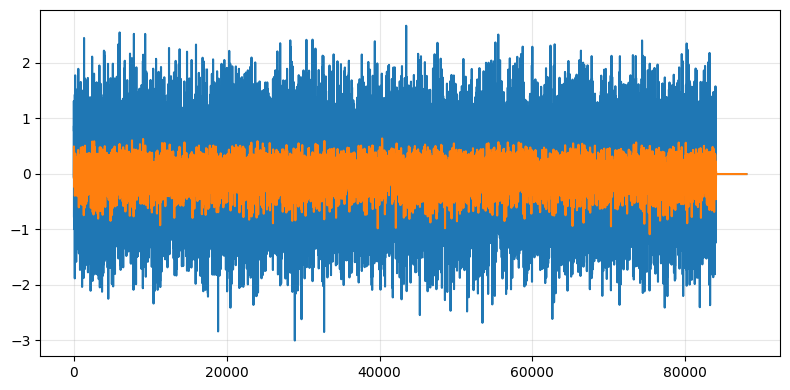

In [ ]:
dls.show_batch()

In [ ]:
#| export
def plot_sequence(axs,in_sig,targ_sig,out_sig=None,**kwargs):
    for j,ax in  enumerate(axs[:-1]):
        ax.plot(targ_sig[:,j])
        if out_sig is not None: 
            ax.plot(out_sig[:,j])
            ax.legend(['y','ŷ'])
            if 'ref' in kwargs:
                ax.plot(kwargs['ref'][:,j]) 
        ax.label_outer()
    axs[-1].plot(in_sig)

In [ ]:
#| export
def plot_seqs_single_figure(n_samples,n_targ,samples,plot_func,outs=None,**kwargs):
    rows=max(1,((n_samples-1) // 3)+1)
    cols=min(3,n_samples)
    fig = plt.figure(figsize=(9,2*cols))
    outer_grid = fig.add_gridspec(rows, cols)
#     import pdb; pdb.set_trace()
    for i in range(n_samples):
        in_sig = samples[i][0]
        targ_sig = samples[i][1]
        if outs is not None: 
            out_sig = outs[i][0]
        inner_grid = outer_grid[i].subgridspec(n_targ+1, 1)
        axs = [fig.add_subplot(inner_grid[j]) for j in range(n_targ+1)]
        plot_func(axs,in_sig,targ_sig,out_sig=out_sig if outs is not None else None,**kwargs)
    plt.tight_layout()

In [ ]:
#| export
def plot_seqs_multi_figures(n_samples,n_targ,samples,plot_func,outs=None,**kwargs):
    for i in range(n_samples):
        fig = plt.figure(figsize=(9,3))
        axs = fig.subplots(nrows=n_targ+1,sharex=True)
        in_sig = samples[i][0]
        targ_sig = samples[i][1]
        if outs is not None:  
            out_sig = outs[i][0]
            
        plot_func(axs,in_sig,targ_sig,out_sig=out_sig if outs is not None else None,**kwargs)
        
        plt.tight_layout()

In [ ]:
#| export
from plum import dispatch


@dispatch
def show_batch(x:TensorSequences, y:TensorSequences, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = samples[0][1].shape[1]
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_sequence, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_sequence, **kwargs)
    return ctxs

In [ ]:
#| export
@dispatch
def show_results(x:TensorSequences, y:TensorSequences, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = samples[0][1].shape[1]
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_sequence,outs, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_sequence,outs, **kwargs)
    return ctxs

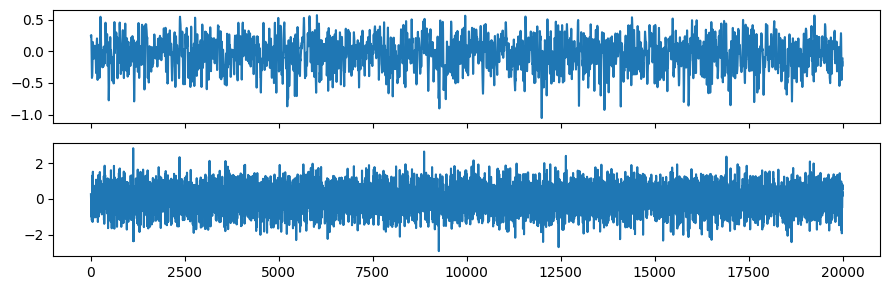

In [ ]:
dls.show_batch()

### Plot Scalars

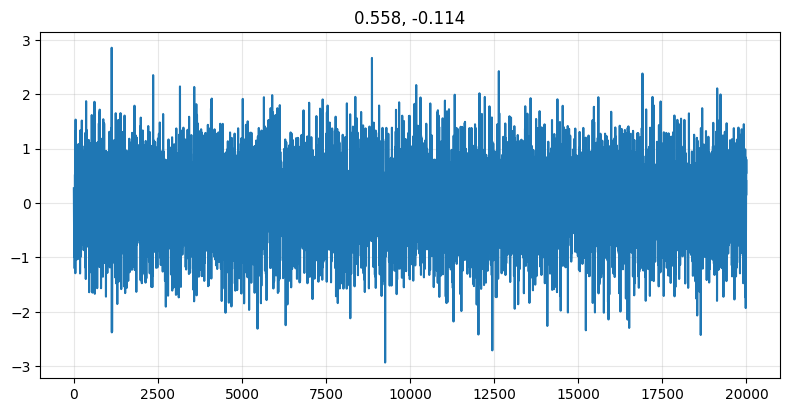

In [ ]:
dls_scalars.show_batch()

In [ ]:
#| include: false
import nbdev

nbdev.nbdev_export()